# Plotting Emissions data from HERWIG Simulation
Rosie Schiffmann <br>
University of Manchester <br>
July 2025

# 1. Introduction
In this notebook, energy and power consumption data obtained from running particle physics event generation simulations using HERWIG is plotted. CPU and RAM energy and power consumption, alongside estimated CO2e emissions was tracked by CodeCarbon. The simulation complexity was varied across runs by changing the total number of events generated by HERWIG, and tracking was performed separately for the integration and generation phases of simulation. During the integration phase, the total cross section is calculated by numerically integrating the squared matrix elements over the allowed phase space of the process. In the generation phase, Herwig samples specific final states based on the probability distribution obtained in the integration phase, and then simulates parton showers, hadronisation, and hadron decays using Monte Carlo techniques.

Data for individual runs from CodeCarbon is stored in CSV files, that follow the naming convention YYYYMMDDType_metadata_EVENTS_JOBS.csv. YYYYMMDD represents the date that the simulations were run. Type is either Int or Gen, to represent data recorded duting the integration or generation phase respectively. EVENTS is the total number of simulated events. This variable can be changed inside the run_herwig_with_cc_loop.ipynb file. JOBS represnets the number of parallel jobs for HERWIG to use, in order to speed up computation by utilising multiple cores. Data that covers the emissions produced by the entire 10 runs as a whole can be found in CSV files YYYYMMDDType_emissions_EVENTS-JOBS.csv.

Plotting functions in this notebook are taken from the emission_tracking.ipynb notebook in https://github.com/rosieschiffmann/event-Transport-Simulation-Energy-Estimation github repository. 

In [96]:
#import python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import re

# 2. Data Processing

Here, we will assimilate all of the individual CSV files into 2 separate master CSV files: "Int_master_emissions_data.csv" and "Gen_master_emissions_data.csv". To do this, mean values were calculated for emissions, duration and CPU/GPU energy and power consumption for each raw data file corresponding to a different number of events.

In [97]:
#identify relevant csv files inside repository
int_files = glob.glob("20250731Int_metadata-*-4.csv")
gen_files = glob.glob("20250731Gen_metadata-*-4.csv")

# int_files = glob.glob("*Int_metadata-*-4.csv")
# gen_files = glob.glob("*Gen_metadata-*-4.csv")

def generate_master_csv(files, type):
	"""
	Function to generate a master csv file containing all data for plotting, for either the integration or generation
	phase of HERWIG.

	Parameters:
	- files (list of str): list of filenames to include in master csv
	- type (str): "Int" or "Gen" for integration phase data or generation phase data respectively
	"""
	summary_data = []

	for file in files:
		#identify and find mean of relevant data from CodeCarbon raw outputs
		df = pd.read_csv(file)
		mean_emissions = df['emissions'].mean()
		mean_duration = df['duration'].mean()
		mean_cpu_power = df['cpu_power'].mean()
		mean_ram_power = df['ram_power'].mean()
		mean_cpu_energy = df['cpu_energy'].mean()
		mean_ram_energy = df['ram_energy'].mean()
		#obtain number of events from filename
		match = re.search(r'_metadata-(\d+)-4\.csv', file)
		events = int(match.group(1)) if match else None

		#propagate errors
		emissions_err = df['emissions'].std() / np.sqrt(len(df['emissions']))
		duration_err = df['duration'].std() / np.sqrt(len(df['duration']))
		cpu_power_err = df['cpu_power'].std() / np.sqrt(len(df['cpu_power']))
		ram_power_err = df['ram_power'].std() / np.sqrt(len(df['ram_power']))
		cpu_energy_err = df['cpu_energy'].std() / np.sqrt(len(df['cpu_energy']))
		ram_energy_err = df['ram_energy'].std() / np.sqrt(len(df['ram_energy']))
		
		#add dictionary of data to summary_data list 
		summary_data.append({
			'filename': file,
			'number_of_events': events,
			'mean_emissions': mean_emissions,
			'emissions_per_event' : mean_emissions / events,
			'emissions_per_event_err' : emissions_err / events,
			'emissions_err' : emissions_err,
			'mean_duration': mean_duration,
			'duration_err' : duration_err,
			'mean_cpu_power': mean_cpu_power,
			'cpu_power_err' : cpu_power_err,
			'mean_ram_power' : mean_ram_power,
			'ram_power_err' : ram_power_err,
			'mean_cpu_energy' : mean_cpu_energy,
			'cpu_energy_err' : cpu_energy_err,
			'mean_ram_energy' : mean_ram_energy,
			'ram_energy_err' : ram_energy_err,
			'cpu_energy_per_event' : mean_cpu_energy / events,
			'cpu_energy_per_event_err' : cpu_energy_err / events,
			'ram_energy_per_event' : mean_ram_energy / events,
			'ram_energy_per_event_err' : ram_energy_err / events,
			'duration_per_event' : mean_duration / events,
			'duration_per_event_err': duration_err / events
		})

	#convert into dataframe and create master csv file.
	summary_df = pd.DataFrame(summary_data)
	summary_df = summary_df.sort_values(by='number_of_events') #sort wrt number_of_events
	summary_df.to_csv(f"{type}_master_emissions_data.csv", index=False)
	return summary_df

int_summary_df = generate_master_csv(int_files, "Int")
gen_summary_df = generate_master_csv(gen_files, "Gen")


# 3. Plotting

In [107]:
def reduced_chi_squared(x, y, y_err, coeffs):
    """
    Calculate the reduced chi-squared for a polynomial fit.

    Parameters:
    - x: 1d array, x-values
    - y: 1d array, observed y-values
    - y_err: 1d array, uncertainties in y
    - coeffs: 1d array, polynomial coefficients from np.polyfit()

    Returns:
    - chi_squared_reduced: float
    """
    model = np.poly1d(coeffs)
    residuals = (y - model(x)) / y_err
    chi_squared = np.sum(residuals**2)
    dof = len(x) - len(coeffs)  # degrees of freedom = N - (fit order + 1)
    return chi_squared / dof

def CPU_and_RAM_plotting(process, df, x_variable, CPU_y_variable, CPU_y_err, RAM_y_variable, RAM_y_err, fit=False, fit_order=None):
    """
    Creates 2 plots (one for CPU and one for RAM), with axis defined by argumants. An optional polyfit is applied and reduced chi squared
    calculated.

    Parameters: 
    - process: string, either 'integration' or 'generation', to reflect whether the plot represents the integration or
    generation phase of simulation
    - df: pandas.DataFrame, containing the data to be plotted.
    - x_variable: string, name of x-axis variable for plotting from dataframe
    - CPU_y_variable: string, name of y-axis variable for CPU plot from dataframe
    - CPU_y_err: string, name of error associated with CPU y-axis variable from dataframe
    - RAM_y_variable: string, name of y-axis variable for RAM plot from dataframe
    - RAM_y_err: string, name of error associated with RAM y-axis variable from dataframe
    - fit: bool, whether or not plot should have fitting
    - fit_order: int, order of fit if fit=True
    """
    plt.rcParams["figure.figsize"] = (14,6)
    fig, ax =  plt.subplots(1,2)

    #define units of selected variables, with default as no units
    units = ['J', 'gCO2e', 's', 'W', '']
    if x_variable=='mean_duration': x_unit=2
    elif x_variable=='number_of_neutrons': x_unit=4
    else: x_unit=4

    if CPU_y_variable=="mean_cpu_energy": y_unit=0
    elif CPU_y_variable=="cpu_energy_per_neutron": y_unit=0
    elif CPU_y_variable=="mean_cpu_power":y_unit=3
    elif CPU_y_variable=="mean_emissions": y_unit=1
    else: y_unit=4
    
    if fit:
        #raise error if fit=True but no fit_order is provided
        if fit_order==None:
            raise ValueError("Order of fit must be provided if fit=True.")
        #CPU data fitting
        if np.any(df[CPU_y_err])==0.0: #do not use error-weighted fitting is errors=0
            coeffs_cpu = np.polyfit(df[x_variable], df[CPU_y_variable], deg=fit_order)
        else:
            coeffs_cpu = np.polyfit(df[x_variable], df[CPU_y_variable], deg=fit_order, w=1/df[CPU_y_err])
        poly_cpu = np.poly1d(coeffs_cpu)
        x_fit = np.linspace(df[x_variable].min(), df[x_variable].max(), 100)
        CPU_chi = reduced_chi_squared(df[x_variable], df[CPU_y_variable], df[CPU_y_err], coeffs_cpu)
        ax[0].plot(x_fit, poly_cpu(x_fit), 'r--', label=f"Fit (order {fit_order}). Reduced-chi-squared = {CPU_chi:.2g}", linewidth = 0.5)
        

        #RAM data fitting
        if np.any(df[RAM_y_err])==0.0: #do not use error-weighted fitting is errors=0
            coeffs_ram = np.polyfit(df[x_variable], df[RAM_y_variable], deg=fit_order)
        else:
            coeffs_ram = np.polyfit(df[x_variable], df[RAM_y_variable], deg=fit_order, w=1/df[RAM_y_err])
        poly_ram = np.poly1d(coeffs_ram)
        RAM_chi = reduced_chi_squared(df[x_variable], df[RAM_y_variable], df[RAM_y_err], coeffs_ram)
        ax[1].plot(x_fit, poly_ram(x_fit), 'r--', label=f"Fit (order {fit_order}). Reduced-chi-squared = {RAM_chi:.2g}", linewidth = 0.5)

    #plotting CPU data
    ax[0].errorbar(df[x_variable], df[CPU_y_variable], yerr = df[CPU_y_err], fmt = "none", capsize = 2, label = "CPU data (Intel Core i5-1235U. Tracking method = cpu_load)")
    ax[0].set_title(f"{CPU_y_variable} vs {x_variable} \n for HERWIG's {process} phase")
    ax[0].set_xlabel(f'{x_variable}, {units[x_unit]}')
    ax[0].set_ylabel(f'{CPU_y_variable}, {units[y_unit]}')

    #plotting RAM data
    ax[1].errorbar(df[x_variable], df[RAM_y_variable], yerr = df[RAM_y_err], fmt = "none", capsize = 2, label = "RAM data (3.681 GB available. Constant 10W power draw)")
    ax[1].set_title(f"{RAM_y_variable} vs {x_variable} \n for HERWIG's {process} phase")
    ax[1].set_xlabel(f'{x_variable}, {units[x_unit]}')
    ax[1].set_ylabel(f'{RAM_y_variable}, {units[y_unit]}')

    #plot details
    for i in range(2):
        ax[i].grid()
        ax[i].legend()
    return None

# 3.1 CPU and RAM Energy

Now, we will plot the CPU and RAM energy consumption side by side, for both the integration and the generation phases of the simulation. We will plot this with respect to simulation duration, and number of events (simulation complexity). We will also plot the energy consumption per event with respect to the number of simulated events.

# 3.1.1 Integration Phase


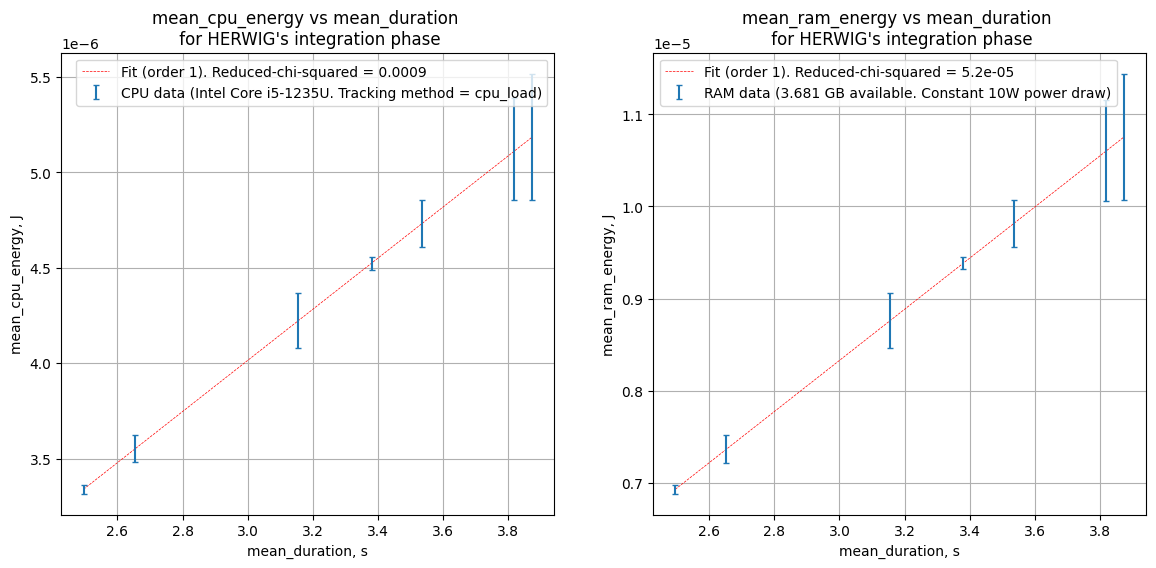

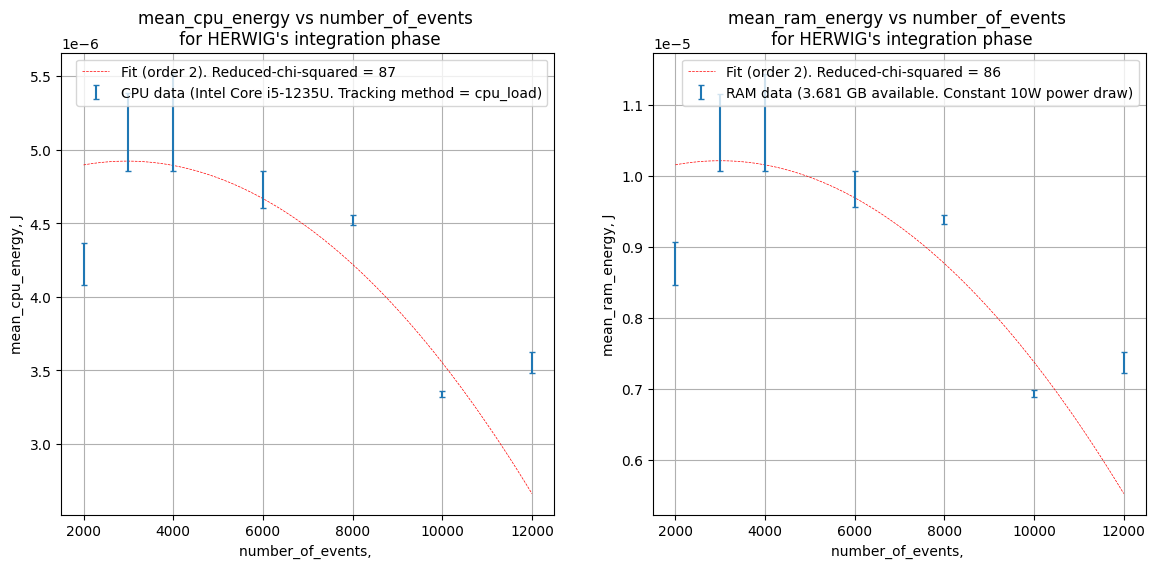

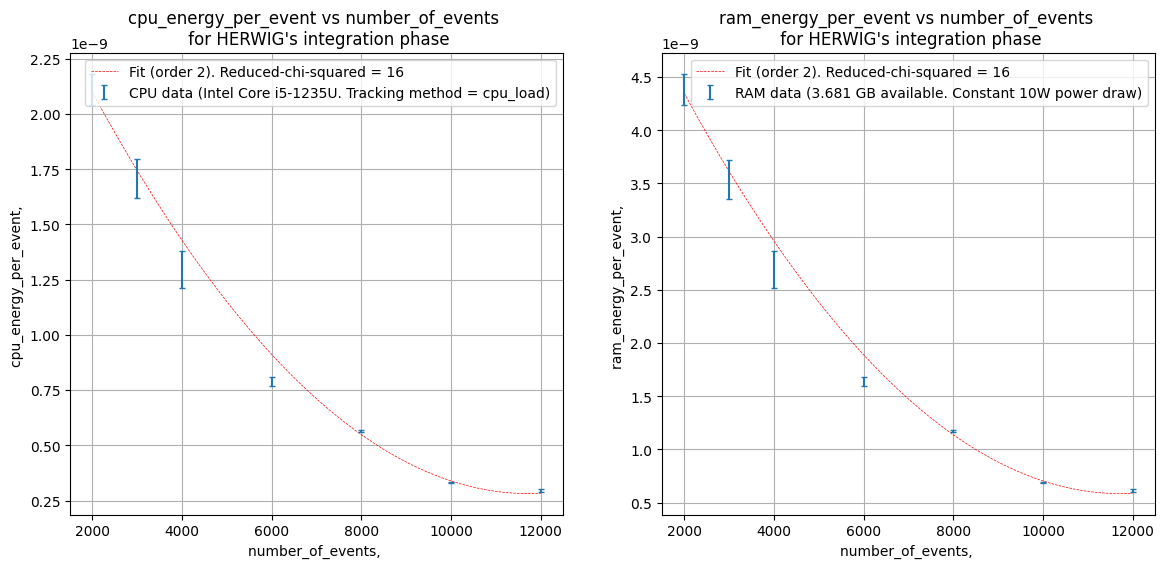

In [108]:
#plot integration phase energy consumption vs simulation duration
CPU_and_RAM_plotting('integration', int_summary_df, "mean_duration", 
         "mean_cpu_energy", "cpu_energy_err", 
         "mean_ram_energy", "ram_energy_err", 
         True, 1)
#plot integration phase energy consumption vs number of events simulated
CPU_and_RAM_plotting('integration', int_summary_df, "number_of_events", 
         "mean_cpu_energy", "cpu_energy_err", 
         "mean_ram_energy", "ram_energy_err", 
         True, 2)
#plot integration phase energy consumption per event vs number of events simulated
CPU_and_RAM_plotting('integration', int_summary_df, "number_of_events", 
                    "cpu_energy_per_event", "cpu_energy_per_event_err", 
                    "ram_energy_per_event", "ram_energy_per_event_err", 
                    True, 2)

# 3.1.2 Generation Phase

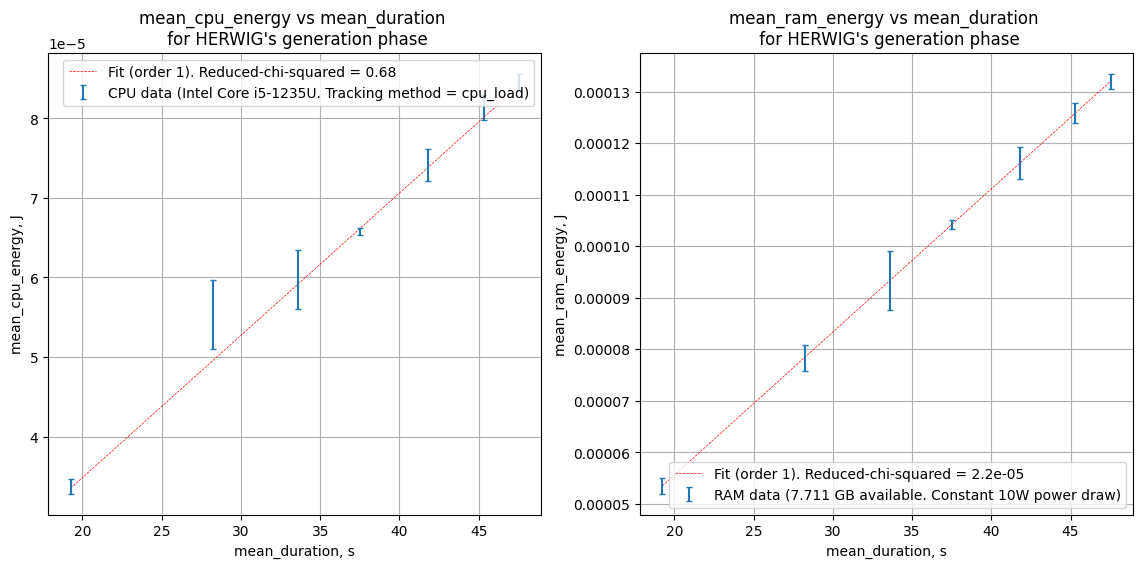

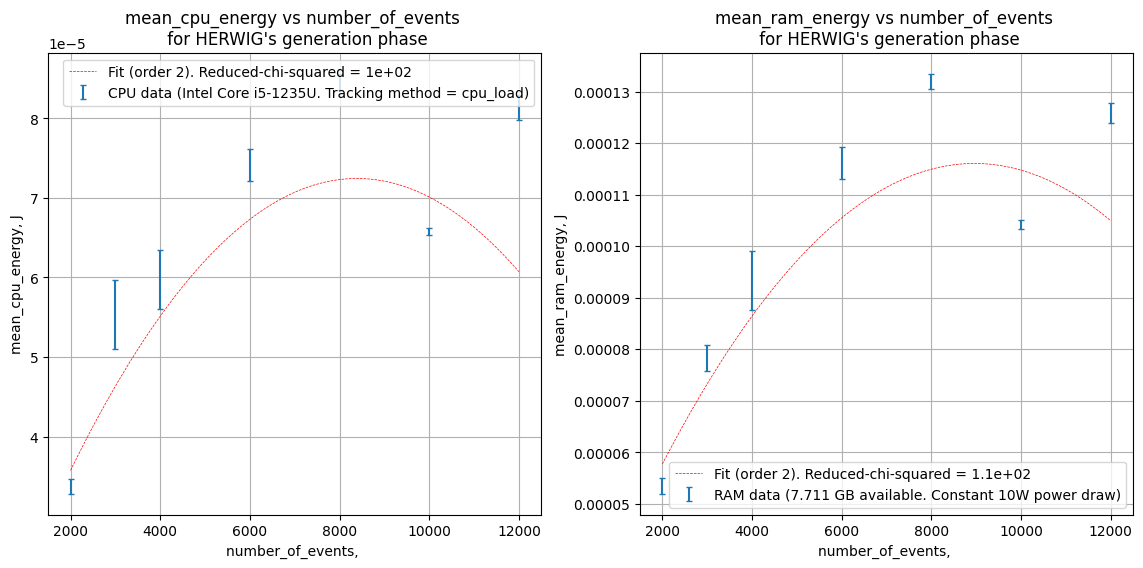

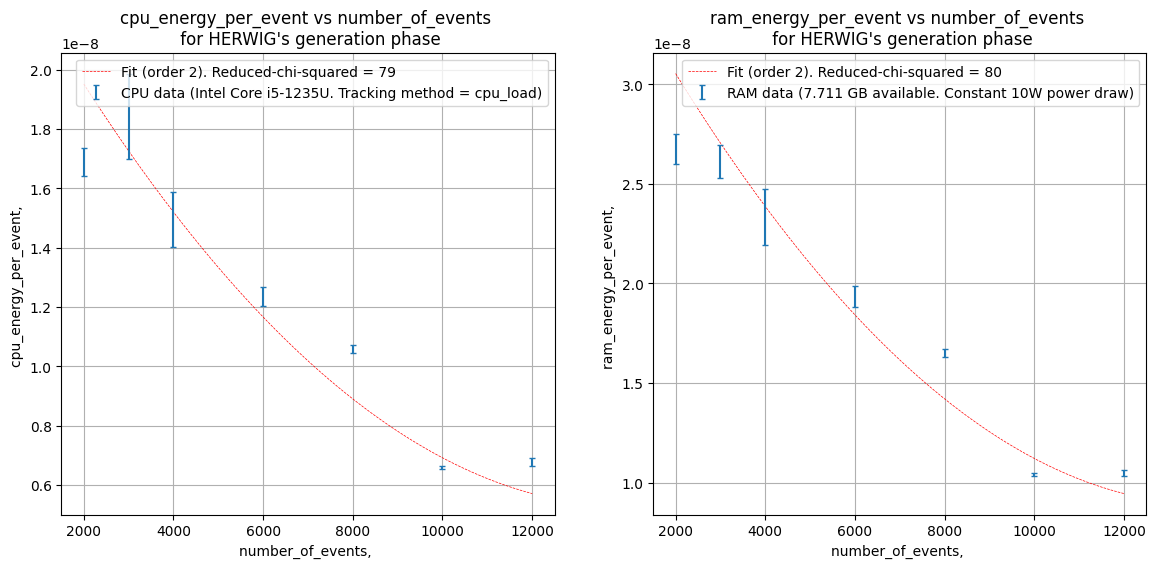

In [100]:
#plot generation phase energy consumption vs simulation duration
CPU_and_RAM_plotting('generation', gen_summary_df, "mean_duration", 
         "mean_cpu_energy", "cpu_energy_err", 
         "mean_ram_energy", "ram_energy_err", 
         True, 1)
#plot generation phase energy consumption vs number of events simulated
CPU_and_RAM_plotting('generation', gen_summary_df, "number_of_events", 
         "mean_cpu_energy", "cpu_energy_err", 
         "mean_ram_energy", "ram_energy_err", 
         True, 2)
#plot generation phase energy consumption per event vs number of events simulated
CPU_and_RAM_plotting('generation', gen_summary_df, "number_of_events", 
                    "cpu_energy_per_event", "cpu_energy_per_event_err", 
                    "ram_energy_per_event", "ram_energy_per_event_err", 
                    True, 2)

# 3.2 CPU and RAM Power

Now, we will plot the CPU and RAM power consumption side by side, for both the integration and the generation phases of the simulation. We will plot this with respect to simulation duration, and number of events (simulation complexity). We expect to observe constant power draw for all types of simulation.

# 3.2.1 Integration Phase

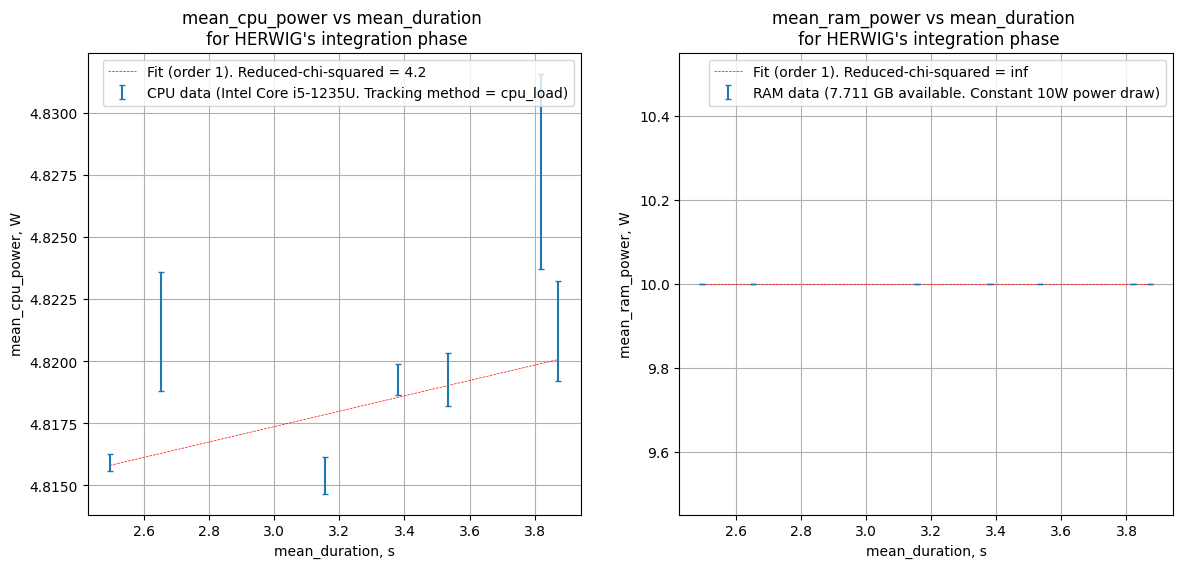

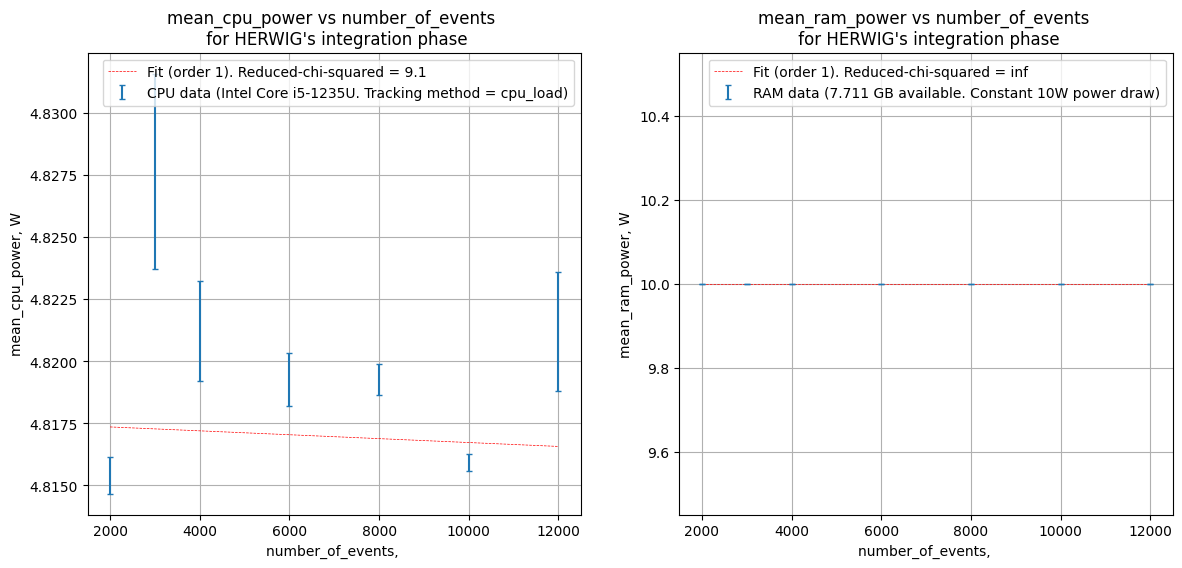

In [101]:
#plot mean power draw vs duration of integration phase of simulation
CPU_and_RAM_plotting('integration', int_summary_df, "mean_duration",
         "mean_cpu_power", "cpu_power_err", 
         "mean_ram_power", "ram_power_err", True, 1)
#plot mean power draw for integration phase of simulation vs number of events simulated
CPU_and_RAM_plotting('integration', int_summary_df, "number_of_events",
         "mean_cpu_power", "cpu_power_err", 
         "mean_ram_power", "ram_power_err", True, 1)

# 3.2.2 Generation Phase

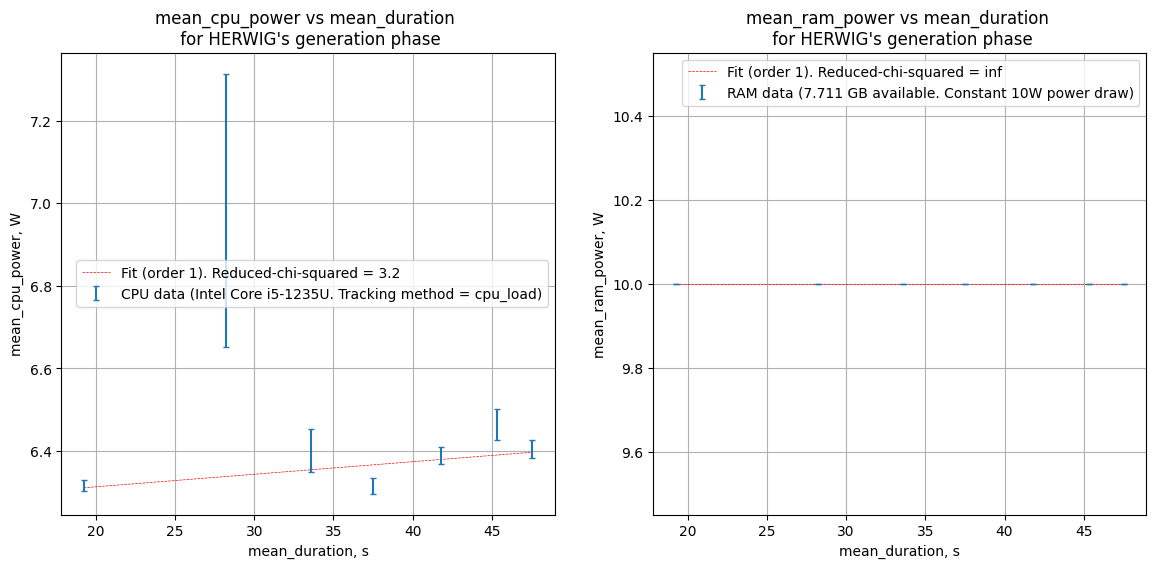

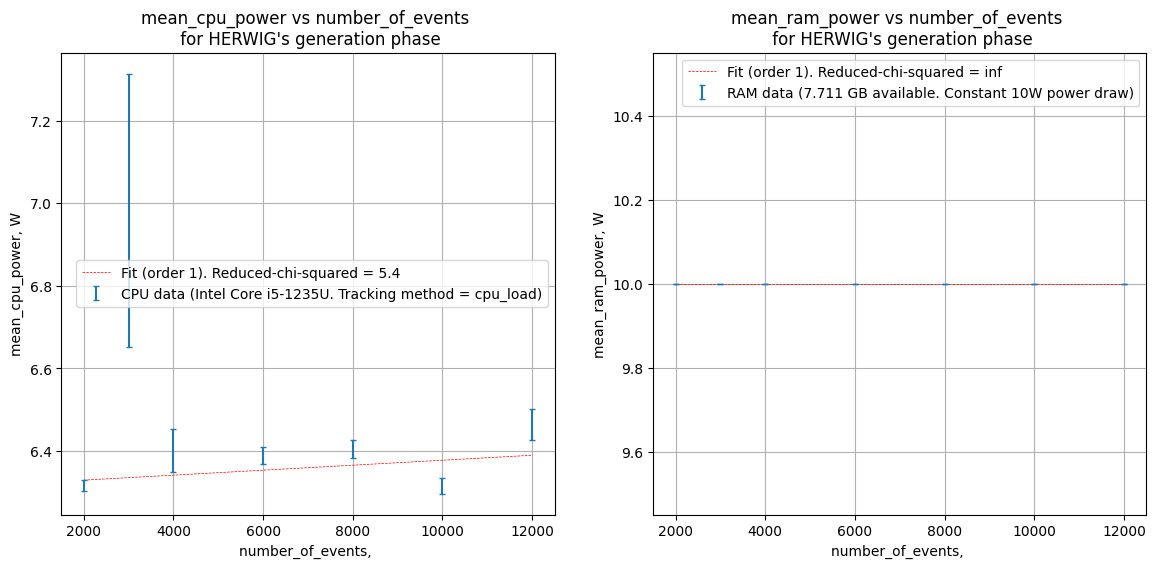

In [102]:
#plot mean power draw vs duration of generation phase of simulation
CPU_and_RAM_plotting('generation', gen_summary_df, "mean_duration",
         "mean_cpu_power", "cpu_power_err", 
         "mean_ram_power", "ram_power_err", True, 1)
#plot mean power draw for generation phase of simulation vs number of events simulated
CPU_and_RAM_plotting('generation', gen_summary_df, "number_of_events",
         "mean_cpu_power", "cpu_power_err", 
         "mean_ram_power", "ram_power_err", True, 1)

# 3.3 Emissions
Here we will plot how simulation emissions (kgCO2e) change with respect to the number of events simulated, and the runtime of the simulation. In order to calculate the emissions of a run, CodeCarbon uses the product of energy consumption and carbon intensity (or emissions rate). Regional carbon intensity data is used for USA and Canada (from www.iea.org), and the energy mix for a given country is used to calculate a carbon intensity value elsewhere (from www.globalpetrolprices.com). If the location is unknown, or carbon intensity data cannot be found from these sources, a default carbon intensity of 475 gCO2eq/kWh may be used. 


In [103]:
def emissions_plotter(process, df, x_variable, y_variable = "mean_emissions", y_err = "emissions_err", fit=False, fit_order=None):
    """
    Creates plot of emissions vs x_variable, with optional polyfit.

    Parameters:
     - process: string, either 'integration' or 'generation', to reflect whether the plot represents the integration or
    generation phase of simulation.
    - df: pandas.DataFrame, containing the data to be plotted.
    - x_variable: string, name of x-axis variable from df for plotting
    - y_variable: string, name of the y-axis variable from df for plotting. Should be either "mean_emissions" or 
    "emissions_per_event". Default = "mean_emissions"
    - y_err: string, name of the error on the y-axis variable from df for plotting. Should be either "emissions_err" or 
    "emissions_per_event_err". Default = "emissions_err"
    - fit: bool, whether or not a polyfit should be performed. Default=False
    - fit_order: int, order of polynomial fit if fit=True. Default=None
    """
    #validate inputs
    allowed_y_variables = ["mean_emissions", "emissions_per_event"]
    allowed_y_errs = ["emissions_err", "emissions_per_event_err"]

    if y_variable not in allowed_y_variables:
        raise ValueError(f"Invalid y_variable: '{y_variable}'. Must be one of {allowed_y_variables}.")

    if y_err not in allowed_y_errs:
        raise ValueError(f"Invalid y_err: '{y_err}'. Must be one of {allowed_y_errs}.")

    #plot emissions data
    plt.figure()
    plt.errorbar(df[x_variable], df[y_variable], yerr=df[y_err], fmt="none", capsize=2, label = "Emissions data. (CPU tracking method = cpu_load. RAM power = 10W)")
    
    #perform polyfit if fit=True
    if fit:
        #raise error if fit=True but no fit_order is provided
        if fit_order==None:
            raise ValueError("Order of fit must be provided if fit=True.")
        
        if np.any(df[y_variable])==0.0: #do not use error-weighted fitting is errors=0
            coeffs = np.polyfit(df[x_variable], df[y_variable], deg=fit_order)
        else: #use error-weighted fitting
            coeffs = np.polyfit(df[x_variable], df[y_variable], deg=fit_order, w=1/df[y_variable])

        #perform polyfit
        poly = np.poly1d(coeffs)
        x_fit = np.linspace(df[x_variable].min(), df[x_variable].max(), 100)
        #calculate reduced chi squared
        chi = reduced_chi_squared(df[x_variable], df[y_variable], df[y_variable], coeffs)

        #plot fit
        plt.plot(x_fit, poly(x_fit), 'r--', label=f"Fit (order {fit_order}). Reduced chi squared = {chi:.2g}", linewidth = 0.5)

    #set x label based on x_variable
    if x_variable=='mean_duration': plt.xlabel(f'Simulation run-time, s')
    else: plt.xlabel(f'{x_variable}')

    #plot details
    if y_variable == 'mean_emissions': 
        plt.ylabel('Emissions, kgCO2e')
        plt.title(f"Mean Emissions vs {x_variable} of Simulation \n for HERWIG's {process} phase")
    if y_variable == 'emissions_per_event': 
        plt.ylabel('Emissions per Event, kgCO2e')
        plt.title(f"Mean Emissions per Event vs {x_variable} of Simulation \n for HERWIG's {process} phase")
    plt.grid()
    plt.legend()
    plt.show()
    return None

# 3.3.1 Integration Phase

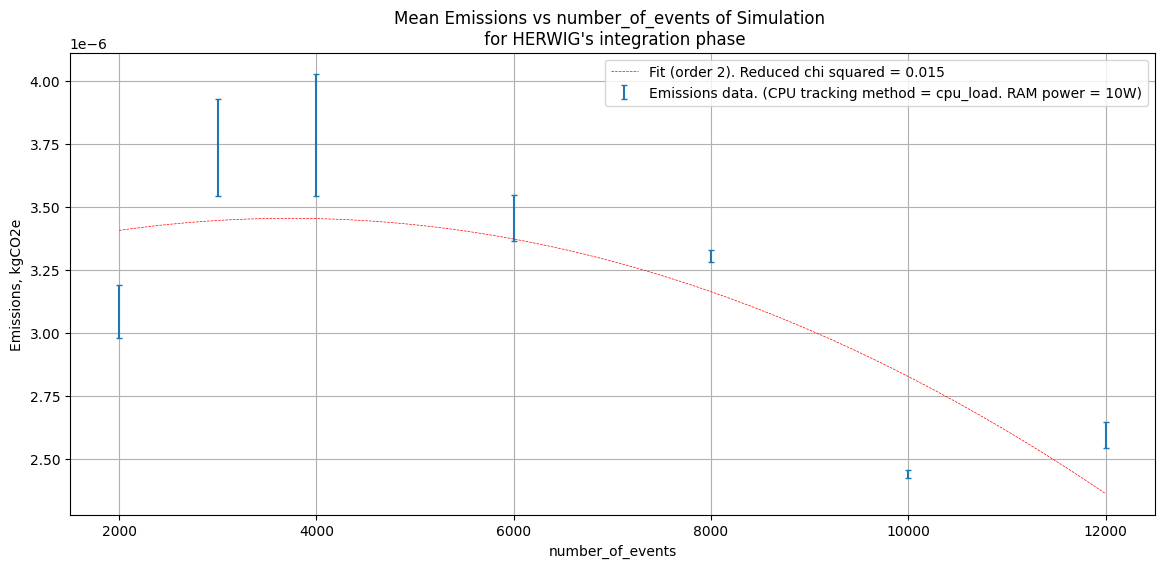

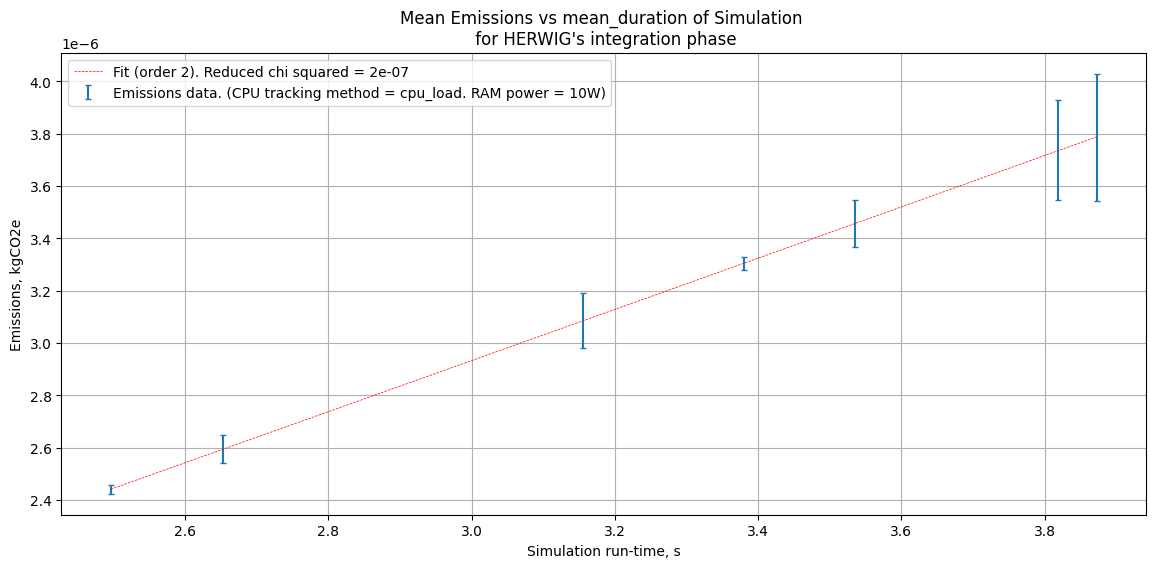

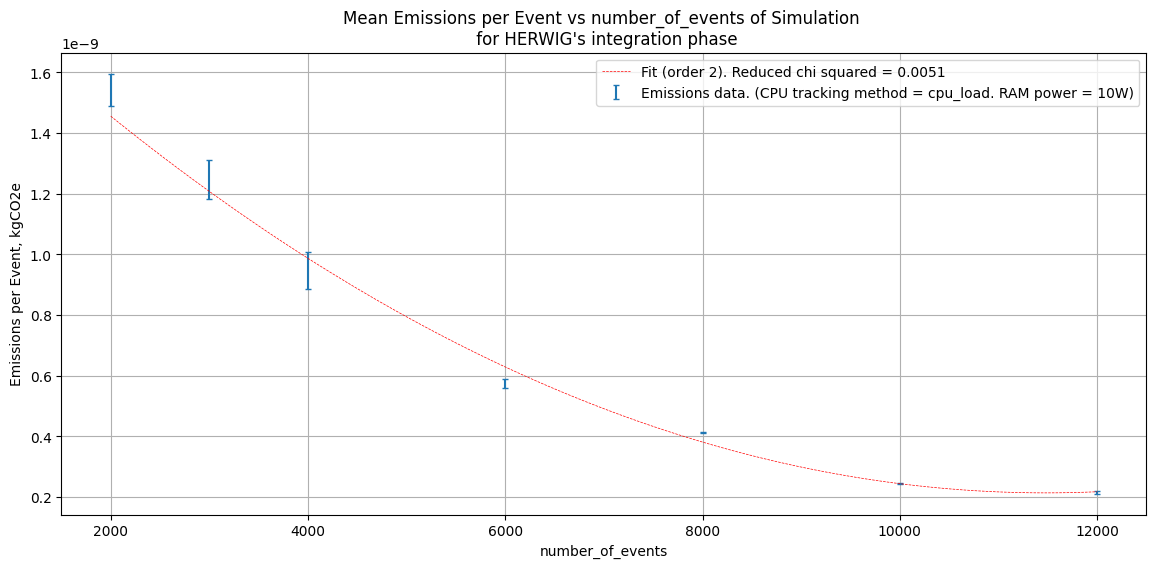

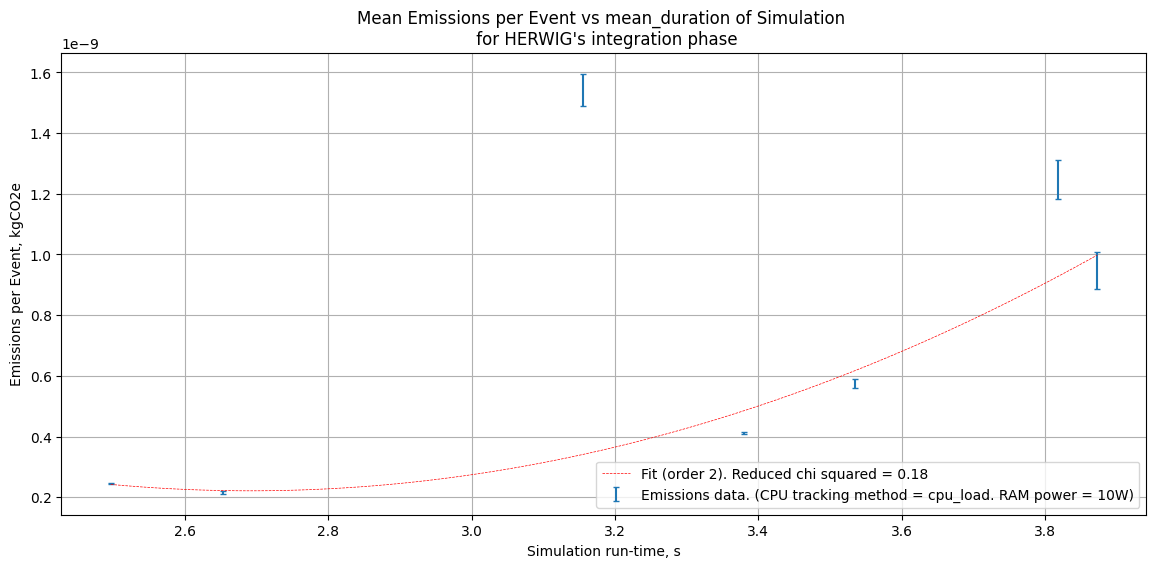

In [104]:
#plot mean emissions in integration phase vs number of events simulated
emissions_plotter('integration', int_summary_df, "number_of_events", 'mean_emissions', 'emissions_err', True, 2)
#plot mean emissions in integration phase vs mean duration of simulation
emissions_plotter('integration', int_summary_df, "mean_duration", 'mean_emissions', 'emissions_err', True, 2)
#plot mean emissions per event in integration phase vs number of events simulated
emissions_plotter('integration', int_summary_df, "number_of_events", 'emissions_per_event', 'emissions_per_event_err', True, 2)
#plot mean emissions per event in integration phase vs mean duration of simulation
emissions_plotter('integration', int_summary_df, "mean_duration", 'emissions_per_event', 'emissions_per_event_err', True, 2)

# 3.3.2 Generation Phase

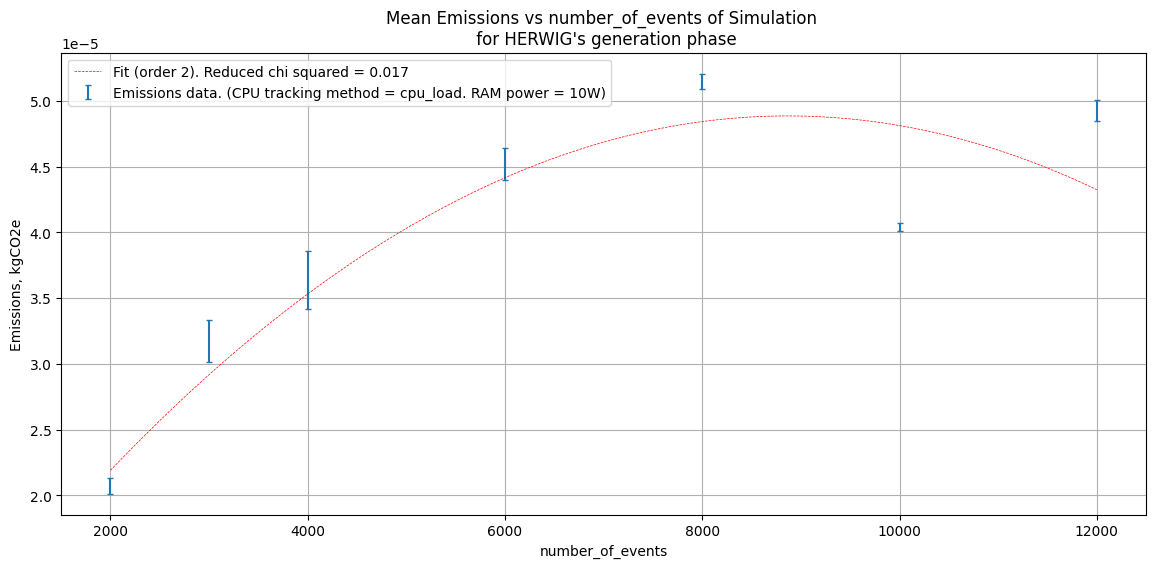

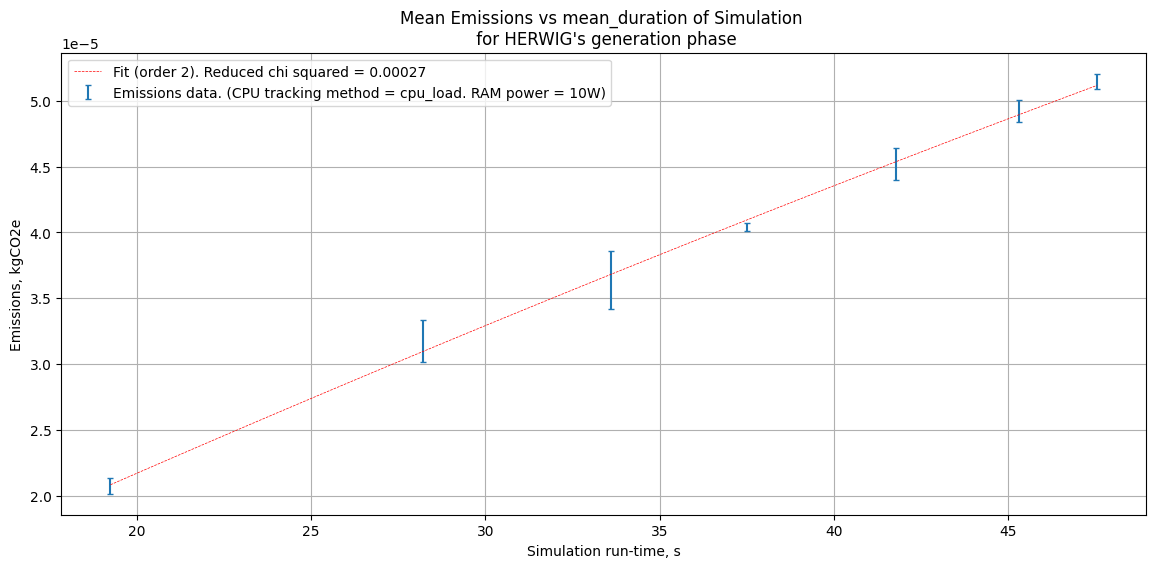

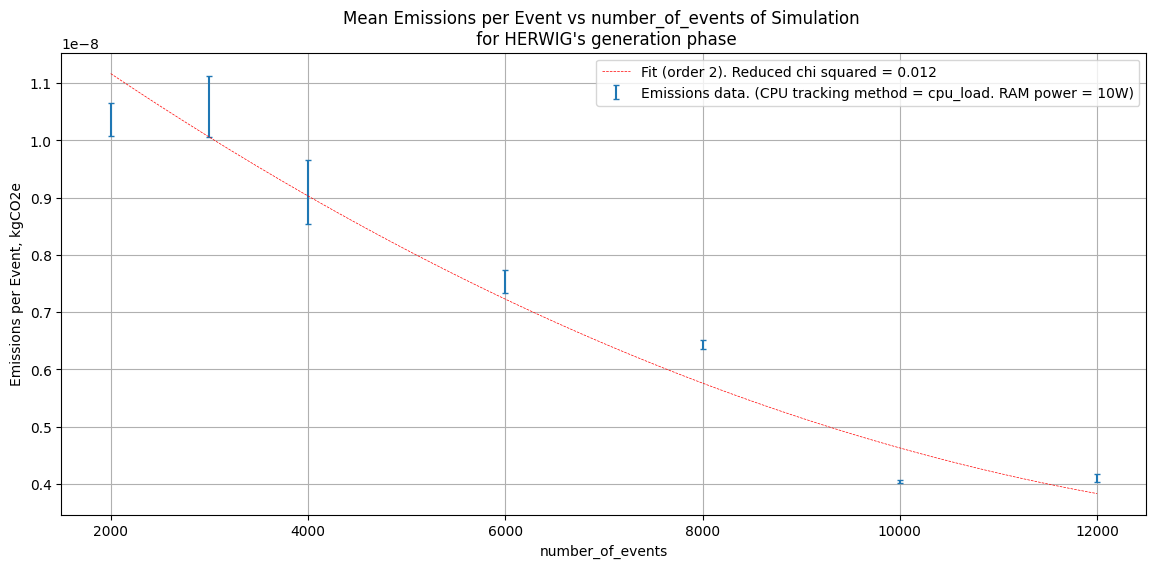

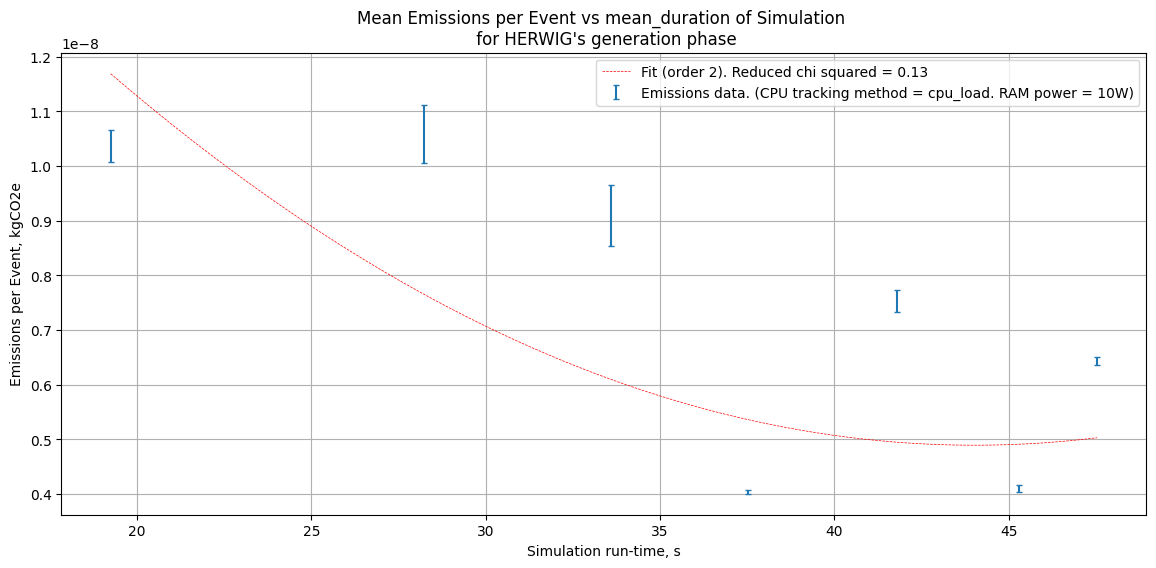

In [105]:
#plot mean emissions in integration phase vs number of events simulated
emissions_plotter('generation', gen_summary_df, "number_of_events", 'mean_emissions', 'emissions_err', True, 2)
#plot mean emissions in integration phase vs mean duration of simulation
emissions_plotter('generation', gen_summary_df, "mean_duration", 'mean_emissions', 'emissions_err', True, 2)
#plot mean emissions per event in integration phase vs number of events simulated
emissions_plotter('generation', gen_summary_df, "number_of_events", 'emissions_per_event', 'emissions_per_event_err', True, 2)
#plot mean emissions per event in integration phase vs mean duration of simulation
emissions_plotter('generation', gen_summary_df, "mean_duration", 'emissions_per_event', 'emissions_per_event_err', True, 2)